In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sympy import symbols, Eq, solve
import matplotlib.pyplot as plt

import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/GX_research/Memory experiment')

## 1.DeepImpute

In [24]:
df = pd.read_csv("./DeepImpute_Dense_Performance/performance.csv")
df.sort_values(by=["Gene Size", "Cell Size", "Percent"]).to_csv("./DeepImpute_Dense_Performance/sorted_performance.csv")
df_subset = df[(df["Cell Size"]==100) | (df["Percent"]==0.1)]
df = df[(df["Cell Size"]!=100) & (df["Percent"]!=0.1)]
df.shape

(148, 4)

In [25]:
# transform
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[["Gene Size", "Cell Size", "Percent"]])
y = df["Peak Memory Usage"].to_numpy()
X.shape

(148, 10)

In [26]:
reg = LinearRegression(fit_intercept=False)
print(reg.fit(X,y).score(X,y))
y_pred = reg.fit(X,y).predict(X)
print(mean_squared_error(y, y_pred, squared=False))
print(np.mean(cross_val_score(reg,X,y,cv=10, scoring="r2")))
print(np.sqrt(np.mean(np.absolute(cross_val_score(reg,X,y,cv=10, scoring='neg_mean_squared_error')))))

0.9976747458059274
987.9516246076553
0.9186456570149903
1166.9378100539495


In [27]:
coef = reg.fit(X, y).coef_
print(len(coef))
coef

10


array([-7.92715785e+01, -3.93780599e-02,  2.53659567e-01,  7.06791006e+01,
        1.74105308e-05,  1.74380772e-05,  7.38363736e-04,  6.42867282e-05,
       -1.27180532e-02, -2.03988416e+00])

In [31]:
"""This function returns a predicted cell size"""
def pred_cell_size_degree2(coef,genesize, percent,ava_mem):
    x = symbols('x',real=True)
    eq1 = Eq(coef[0] + coef[1]*genesize + coef[2]*x + coef[3]*percent + coef[4]*(genesize**2) + coef[5]*(genesize*x) + coef[6]*(genesize*percent)+ coef[7]*(x**2) + coef[8]*(x*percent)+coef[9]*(percent**2)-ava_mem)
    if len(solve(eq1)) == 0:
        return None
    ret = max(solve(eq1))
    return int(ret) if ret > 0 else None

print(pred_cell_size_degree2(coef, 58347, 0.01, 60000))
## Problem exists when ava_men < 50,000
# for i in [10000,20000,30000,40000,50000,60000]:
#     for j in [0.5,1,2,5,10,20,30]:
#         sol = pred_cell_size_degree2(coef, i, j, 50000)
#         print(i,j)
#         print(sol)
#         if sol is not None:
#             print(reg.predict(poly.transform([[i,sol,j]])))


/usr/local/lib/python3.7/dist-packages/sympy/core/relational.py:496: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  deprecated_since_version="1.5"


2197


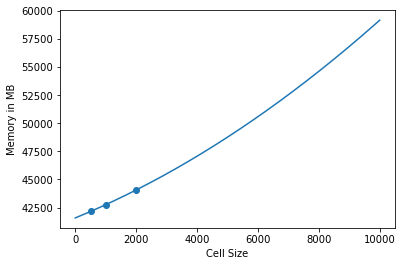

In [ ]:

tmp = df[(df["Gene Size"]==50000) & (df["Percent"]==1)][["Gene Size", "Cell Size", "Percent"]]
plt.scatter(tmp["Cell Size"], reg.fit(X,y).predict(poly.fit_transform(tmp)))
plt.xlabel("Cell Size")
plt.ylabel("Memory in MB")
genesize = 50000
percent = 1
x_ = np.linspace(0,10000,10000)
y_ = coef[7]*(x_**2) + coef[2]*x_ + coef[5]*(genesize*x_) + coef[8]*(x_*percent) + coef[0] + coef[1]*genesize +  coef[3]*percent + coef[4]*(genesize**2) +  coef[6]*(genesize*percent)+ coef[9]*(percent**2)
plt.plot(x_,y_)



In [ ]:
pred_cell_size_degree2(coef, 50000, 1, 45000)

/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


2660

In [ ]:
df_subset[df_subset["Gene Size"]==50000]

,Gene Size,Cell Size,Percent,Peak Memory Usage
68,50000,100,0.1,574.720501
69,50000,100,0.5,6711.749487
70,50000,100,1.0,17273.445055
71,50000,100,10.0,43001.075029
72,50000,100,2.0,32374.748652
73,50000,100,20.0,43004.509382
74,50000,100,30.0,43004.508239
75,50000,100,5.0,42487.649684
76,50000,500,0.1,7020.530327
168,50000,1000,0.1,17948.272286


In [15]:
df2 = pd.read_csv("./DeepImpute_Dense_Performance/time_performance.csv")
# df2 = df2[(df2["Cell Size"]!=100) & (df2["Percent"]!=0.1)]

In [16]:
poly = PolynomialFeatures(2)
X = poly.fit_transform(df2[["Gene Size", "Cell Size", "Percent"]])
y = df2["Time"].to_numpy()
X.shape

(219, 10)

In [17]:
rs = np.mean(cross_val_score(reg,X,y,cv=10, scoring="r2"))
print(rs)
rmse = np.mean(np.sqrt(np.absolute(cross_val_score(reg,X,y,scoring='neg_mean_squared_error',cv=10))))
rmse

0.04000604525181983


198.30696536516945

In [18]:
test = poly.fit_transform([[10000,3000,0.1]])
reg.fit(X,y).predict(test)

array([183.51010136])

In [19]:
reg.fit(X, y).coef_

array([-3.26404988e+01, -5.24450864e-04,  3.58268991e-03,  2.43827171e+01,
        9.53964303e-08,  9.82786054e-06,  6.44704782e-05, -1.07122863e-05,
        6.27759697e-04, -8.91337904e-01])

## 2.ScanpyGeneFilter

In [11]:
df_gf = pd.read_csv("./Genefilter_Dense_Performance/performance.csv")
df_gf.sort_values(by=["Gene Size", "Cell Size", "Percent"]).to_csv("./Genefilter_Dense_Performance/sorted_performance.csv")
# df2 = df[df["Percent"]==0.1]
# df = df[(df["Cell Size"]!=100) & (df["Percent"]!=0.1)]
df_gf.shape

(166, 4)

In [12]:
# transform
poly = PolynomialFeatures(2)
X = poly.fit_transform(df_gf[["Gene Size", "Cell Size", "Percent"]])
y = df_gf["Peak Memory Usage"].to_numpy()
X.shape

(166, 10)

In [13]:
reg = LinearRegression(fit_intercept=False)
print(reg.fit(X,y).score(X,y))
y_pred = reg.fit(X,y).predict(X)
print(mean_squared_error(y, y_pred, squared=False))
print(np.mean(cross_val_score(reg,X,y,cv=10, scoring="r2")))
print(np.sqrt(np.mean(np.absolute(cross_val_score(reg,X,y,cv=10, scoring='neg_mean_squared_error')))))

0.9988237862735335
44.106084394191825
0.9807633647208176
84.08362634782486


In [14]:
coef_genefilter = reg.fit(X, y).coef_
coef_genefilter

array([ 3.85059527e+01, -2.07428193e-02,  3.88535575e-04, -1.20825079e+01,
        3.60016241e-07,  1.46660241e-05,  2.50506298e-03, -3.04880769e-08,
        2.61331814e-04,  1.24450822e-01])

In [ ]:
def pred_cell_size_degree2(coef,cellsize, percent,ava_mem):
    x = symbols('x',real=True)
    eq1 = Eq(coef[0] + coef[1]*x + coef[2]*cellsize + coef[3]*percent + coef[4]*(x**2) + coef[5]*(x*cellsize) + coef[6]*(x*percent)+ coef[7]*(cellsize**2) + coef[8]*(cellsize*percent)+coef[9]*(percent**2)-ava_mem)
    if len(solve(eq1)) == 0:
        return 1000 # CHANGE THIS DEFAULT RETURN
    ret = min(solve(eq1)) if min(solve(eq1)) > 0 else max(solve(eq1))
    return int(ret) if ret > 0 else 1000 # CHANGE THIS DEFAULT RETURN

# sol = pred_cell_size_degree2(coef_genefilter, 60000, 20, 30000)
# reg.predict(poly.transform([[sol,60000,20]]))


for i in [10000,20000,30000,40000,50000,60000]:
    for j in [0.5,1,2,5,10,20,30]:
        sol = pred_cell_size_degree2(coef_genefilter, i, j, 125821)
        print(i,j)
        print(sol)
        if sol is not None:
            print(reg.predict(poly.transform([[sol,i,j]])))

/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


[-793532.152483869, 440298.220436623]
10000 0.5
440298
[125820.9020823]
[-795782.407088665, 439069.377864727]
10000 1
439069
[125820.83201398]
[-800295.910583513, 436624.687006192]
10000 2
436624
[125820.69406841]
[-813939.588828051, 429393.782190577]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


10000 5
429393
[125820.64987591]
[-837017.587382905, 417680.808978515]
10000 10
417680
[125820.63457509]
[-884401.451344938, 395482.729406711]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


10000 20
395482
[125820.66390483]
[-933342.397217582, 374841.731745520]
10000 30
374841
[125820.65537181]
[-1083176.52080362, 322571.410900260]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


20000 0.5
322571
[125820.79204669]
[-1085865.38377476, 321781.176694715]
20000 1
321781
[125820.91045544]
[-1091251.77488107, 320209.373447641]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


20000 2
320209
[125820.81023303]
[-1107479.43014858, 315562.445654997]
20000 5
315562
[125820.77168291]
[-1134748.26614786, 308040.309887355]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


20000 10
308040
[125820.83903608]
[-1190080.81748474, 293790.917690404]
20000 20
293790
[125820.50975364]
[-1246401.46224072, 280529.618912548]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


20000 30
280529
[125820.65977154]
[-1414934.50303287, 246958.215273405]
30000 0.5
246958
[125820.87120014]
[-1417900.90895033, 246445.524014168]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


30000 1
246445
[125820.68601513]
[-1423838.87671402, 245425.297424474]
30000 2
245425
[125820.82125916]
[-1441693.48447813, 242405.322128438]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


30000 5
242405
[125820.80469262]
[-1471583.30288530, 237504.168768688]
30000 10
237504
[125820.89615676]
[-1531833.01582262, 228171.938172168]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


30000 20
228171
[125820.40554594]
[-1592665.33392989, 219422.312745608]
30000 30
219422
[125820.79597075]
[-1772511.01227966, 197163.546664086]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


40000 0.5
197163
[125820.6123525]
[-1775643.42187589, 196816.859083616]
40000 1
196816
[125820.38994975]
[-1781911.27300865, 196126.515862993]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


40000 2
196126
[125820.63264078]
[-1800738.77647023, 194079.436264428]
40000 5
194079
[125820.68668937]
[-1832195.79294433, 190745.480971607]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


40000 10
190745
[125820.64971245]
[-1895387.49612556, 184355.240619002]
40000 20
184355
[125820.81983867]
[-1958924.78761041, 178310.588570019]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


40000 30
178310
[125820.54713113]
[-2145625.17396207, 162906.530490384]
50000 0.5
162906
[125820.55910482]
[-2148858.40114420, 162660.660495817]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


50000 1
162660
[125820.45034584]
[-2155326.68990226, 162170.754900492]
50000 2
162170
[125820.370159]
[-2174746.06219400, 160715.544132086]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


50000 5
160715
[125820.54249161]
[-2207158.93356044, 158337.443731602]
50000 10
158337
[125820.62211064]
[-2272153.95866352, 153750.525300852]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


50000 20
153750
[125820.54122071]
[-2337360.97343881, 149375.596542299]
50000 30
149375
[125820.46593636]
[-2528366.86110340, 138277.039775603]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


60000 0.5
138277
[125820.96181403]
[-2531663.80642267, 138094.887918178]
60000 1
138094
[125820.14657196]
[-2538258.84981111, 137731.736953239]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


60000 2
137731
[125820.29001939]
[-2558053.10597375, 136651.410055726]
60000 5
136651
[125820.60218967]
[-2591073.32608885, 134880.658403909]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(
/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


60000 10
134880
[125820.35385065]
[-2657220.97988864, 131446.368669856]
60000 20
131446
[125820.62986822]
[-2723503.72120584, 128147.166453226]
60000 30
128147
[125820.82911236]


/Users/harrisonli/miniforge3/lib/python3.9/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


In [21]:
df2 = pd.read_csv("./Genefilter_Dense_Performance/time_performance.csv")
# df2 = df2[(df2["Cell Size"]!=100) & (df2["Percent"]!=0.1)]
poly = PolynomialFeatures(2)
X = poly.fit_transform(df2[["Gene Size", "Cell Size", "Percent"]])
y = df2["Time"].to_numpy()
print(X.shape)
rs = np.mean(cross_val_score(reg,X,y,cv=10, scoring="r2"))
print(rs)
rmse = np.mean(np.sqrt(np.absolute(cross_val_score(reg,X,y,scoring='neg_mean_squared_error',cv=10))))
print(rmse)
reg.fit(X, y).coef_

(166, 10)
0.7874205928826663
6.784890793506669


array([ 1.12068964e+01, -3.85861753e-03, -2.63593155e-04, -1.94885430e+00,
        9.27135025e-08,  3.48370226e-07,  3.84903711e-04, -3.29570701e-10,
        3.63668853e-05,  2.58543498e-02])

## 3.1 PCA

In [ ]:
df = pd.read_csv("./PCA_Performance/bottom_up/performance.csv")
print(df.shape)
print(max(df["Peak Memory Usage"]))

(35, 4)
14591.005325317383


In [ ]:
# transform
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[["Gene Size", "Cell Size", "Percent"]])
y = df["Peak Memory Usage"].to_numpy()
X.shape
memory = df["Peak Memory Usage"].to_numpy()

In [ ]:
reg = LinearRegression(fit_intercept=False)
print(reg.fit(X,y).score(X,y))
y_pred = reg.fit(X,y).predict(X)
print(mean_squared_error(y, y_pred, squared=False))
print(np.mean(cross_val_score(reg,X,y,cv=10, scoring="r2")))
print(np.sqrt(np.mean(np.absolute(cross_val_score(reg,X,y,cv=10, scoring='neg_mean_squared_error')))))

0.9382973841875881
1038.0547674905638
-9.422770201064044
3269.774197058613


In [ ]:
"""This function returns a predicted memory usage"""
def pred_memory_degree2(coef,genesize, cellsize, percent):
    memory = coef[0] + coef[1]*genesize + coef[2]*cellsize + coef[3]*percent + coef[4]*(genesize**2) + \
    coef[5]*(genesize*cellsize) + coef[6]*(genesize*percent)+ coef[7]*(cellsize**2) + coef[8]*(cellsize*percent)+coef[9]*(percent**2)
    return memory

In [ ]:
pred_memory_degree2(reg.coef_, 60000, 60000, 30)

17967.721132814095

##3.2 IPCA

In [ ]:
df = pd.read_csv("./PCA_Performance/top_down/performance.csv")
print(df.shape)
print(max(df["Peak Memory Usage"]))

(290, 4)
40196.806697845466


In [ ]:
# transform
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[["Gene Size", "Cell Size", "Percent"]])
y = df["Peak Memory Usage"].to_numpy()/5
X.shape

(290, 10)

In [ ]:
reg = LinearRegression(fit_intercept=False)
print(reg.fit(X,y).score(X,y))
y_pred = reg.fit(X,y).predict(X)
print(mean_squared_error(y, y_pred, squared=False))
print(np.mean(cross_val_score(reg,X,y,cv=10, scoring="r2")))
print(np.sqrt(np.mean(np.absolute(cross_val_score(reg,X,y,cv=10, scoring='neg_mean_squared_error')))))

0.988843153375138
141.84559886487898
0.4207883116054405
181.73865833075968


In [ ]:
"""This function returns a predicted cell size"""
def pred_cell_size_degree2(coef,orgcell,genesize, percent,ava_mem):
    x = symbols('x',real=True)
    eq1 = Eq(coef[0] + coef[1]*genesize + coef[2]*x + coef[3]*percent + coef[4]*(genesize**2) + coef[5]*(genesize*x) + coef[6]*(genesize*percent)+ coef[7]*(x**2) + coef[8]*(x*percent)+coef[9]*(percent**2)-ava_mem*(x/orgcell))
    if len(solve(eq1)) == 0:
        return None
    sol = int(max(solve(eq1)))
    # MAKE SURE within range (1000, orgcell)
    if sol < 1000:
      return 1000
    elif sol > orgcell:
      return orgcell
    else:
      return sol


In [ ]:
orgcell = 60000
genesize = 30000
percent = 30
ava_mem = 25000 # 10G
for i in range(1000, 60000, 1000):
  print("=====>")
  print(i)
  print(pred_cell_size_degree2(reg.coef_,i,genesize, percent,ava_mem))

=====>
1000
1000
=====>
2000


/usr/local/lib/python3.7/dist-packages/sympy/core/relational.py:496: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  deprecated_since_version="1.5"


2000
=====>
3000
3000
=====>
4000
4000
=====>
5000
5000
=====>
6000
6000
=====>
7000
7000
=====>
8000
8000
=====>
9000
9000
=====>
10000
10000
=====>
11000
11000
=====>
12000
12000
=====>
13000
13000
=====>
14000
14000
=====>
15000
15000
=====>
16000
16000
=====>
17000
17000
=====>
18000
18000
=====>
19000
19000
=====>
20000
20000
=====>
21000
21000
=====>
22000
22000
=====>
23000
23000
=====>
24000
24000
=====>
25000
25000
=====>
26000
26000
=====>
27000
27000
=====>
28000
28000
=====>
29000
29000
=====>
30000
30000
=====>
31000
31000
=====>
32000
32000
=====>
33000
33000
=====>
34000
34000
=====>
35000
35000
=====>
36000
36000
=====>
37000
37000
=====>
38000
38000
=====>
39000
39000
=====>
40000
40000
=====>
41000
41000
=====>
42000
42000
=====>
43000
37260
=====>
44000
30932
=====>
45000
24946
=====>
46000
19322
=====>
47000
14127
=====>
48000
9532
=====>
49000
5896
=====>
50000
3571
=====>
51000
2338
=====>
52000
1690
=====>
53000
1315
=====>
54000
1078
=====>
55000
1000
=====>
560